# CREDIT CARD APPROVAL FROM CUSTOMER APPLICATION/ CREDIT HISTORY
(Kaggle)<br><br>
**Objective** is to build a model to predict credit card approval on the basis of information about the customer. The data is unlabelled, but we are provided with a file of credit histories to construct labels. Historically linear logistic regression has been used to build this kind of model. Is it possible to build a more sophisticated model while maintaining transparency of decision?

**Contents:**<a id='s0'></a>
1. [Build data labels](#s1)
2. [Exploratory data analysis](#s2)
3. [Feature engineering](#s3)
4. [Feature selection](#s4)
5. [Model building](#s5)
6. [Evaluation](#s6)
7. [Conclusions](#s7)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cust = pd.read_csv("application_record.csv")
cred = pd.read_csv("credit_record.csv")

## 1. Build data labels<a id='s1'></a>
The credit_record dataset provides historic monthly STATUS flag for account holders.

* C = payments up to date
* 0 = up to 1 month in arrears
* 1 = up to 2 months in arrears (etc. 2,3,4,5)
* X = No debt<br><br>
ID is link to individual in credit application<br><br>
MONTHS_BALANCE indicates age of the data: -60 is 5 years ago and 0 is current

In [3]:
cred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [4]:
cred['ID'].nunique()

45985

In [5]:
cred['STATUS'].value_counts()

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64

In [6]:
(cred['MONTHS_BALANCE'].min(),cred['MONTHS_BALANCE'].max())

(-60, 0)

**RISK SCORING PROPOSAL:**
1. Remove 'X' records (no debt) because this is irrelevant to credit risk.
2. Score each month as per STATUS flag: 0..4
3. Score 'C' (payments up to date) as -1 (reduced credit risk)
4. Attenuate score by 1% per month (linear) because recent data should be more relevant.<br>
Scoring function will be:

In [7]:
def apply_score(row):
    statusList = ['C', '0', '1', '2', '3', '4', '5']
    attenuation = 0.01
    return (statusList.index(row['STATUS']) - 1)*(1+row['MONTHS_BALANCE']*attenuation)

Remove STATUS 'X' rows from data (which make no contribution), apply scoring function and sum by ID

<AxesSubplot:xlabel='score', ylabel='Count'>

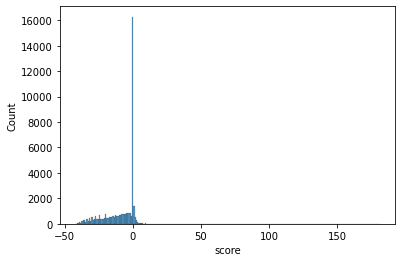

In [8]:
cred = cred[cred['STATUS'] != 'X']
cred['score'] = cred.apply(lambda row: apply_score(row), axis=1)
profile = cred.groupby('ID').sum('score')['score'].sort_values()
sns.histplot(data=profile)

In [9]:
a = len(profile[profile < 0])
b = len(profile[profile > 0])
c = len(profile) - a - b
d = len(profile)
print(f"There are {d} credit records, of which {a} are good (score below 0),\n{c} with exactly zero score, and {b} bad (score above 0).")

There are 41449 credit records, of which 22524 are good (score below 0),
16201 with exactly zero score, and 2724 bad (score above 0).


The zero score is achievable only by paying consistently 1 month in arrears. While this does represent a degree of credit risk it is also highly profitable business for the lender since these customers will be paying substantial interest charges. We therefore propose to exclude them from the bad risk label. We will set the high risk cut off at score > 0:

In [10]:
label = profile > 0

In [11]:
print(f"Positives = {100*np.mean(label):.2f}%")

Positives = 6.57%


[Back to top](#s0)

## 2. Exploratory data analysis: Customer information file<a id='s2'></a>

#### Overview

In [12]:
cust.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [13]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [14]:
cust.nunique()

ID                     438510
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
dtype: int64

Remove non-unique IDs and join to labels, keeping only labelled data. We have 438510 unique ID's in the cust file, but only 45985 in the credit file, which means that at least 90% of the data cannot be labelled and will be discarded.

In [15]:
cust.drop_duplicates(subset=['ID'],keep=False, inplace=True)
cust.set_index('ID',inplace=True)
cust = pd.concat([cust,label], axis=1, join="inner")
print(f'{len(cust)} records remaining')
print(f'Positives = {100*cust["score"].mean():.2}%')

33110 records remaining
Positives = 6.5%


### Numeric fields
CNT_CHILDREN, AMT_INCOME_TOTAL, DAYS_BIRTH, DAYS_EMPLOYED, CNT_FAM_MEMBERS

In [16]:
cust[['CNT_CHILDREN','AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED','CNT_FAM_MEMBERS']].describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS
count,33110.000000,3.311000e+04,33110.000000,33110.000000,33110.000000
mean,0.427756,1.858772e+05,-16007.262489,60031.029085,2.194654
std,0.741716,1.014124e+05,4213.387673,138345.184712,0.911076
min,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.000000
25%,0.000000,1.215000e+05,-19495.000000,-3159.000000,2.000000
50%,0.000000,1.575000e+05,-15646.000000,-1552.000000,2.000000
75%,1.000000,2.250000e+05,-12461.000000,-405.000000,3.000000
max,19.000000,1.575000e+06,-7705.000000,365243.000000,20.000000


__Comments:__<br>
DAYS_EMPLOYED is problematic: should be a negative number (counting back to employment date), but max is 365243. Replace out of range values with median value of the feature.

In [17]:
med_de = cust[cust["DAYS_EMPLOYED"] < 0]["DAYS_EMPLOYED"].median()
cust['DAYS_EMPLOYED'].mask(cust['DAYS_EMPLOYED'] > 0, med_de, inplace=True)
print(f"Years employed from {-int(cust['DAYS_EMPLOYED'].max()/365)} to {-int(cust['DAYS_EMPLOYED'].min()/365)}")

Years employed from 0 to 43


### Categorical fields

There are no NaNs apart from OCCUPATION_TYPE. FIX: create new category "Unspecified".

In [18]:
cust['OCCUPATION_TYPE'] = cust['OCCUPATION_TYPE'].fillna("Unspecified")

In [19]:
cust['OCCUPATION_TYPE'].value_counts()

Unspecified              10373
Laborers                  5601
Core staff                3250
Sales staff               3156
Managers                  2695
Drivers                   1934
High skill tech staff     1269
Medicine staff            1124
Accountants               1106
Cooking staff              587
Security staff             547
Cleaning staff             511
Private service staff      293
Waiters/barmen staff       163
Low-skill Laborers         159
Secretaries                142
HR staff                    76
Realty agents               67
IT staff                    57
Name: OCCUPATION_TYPE, dtype: int64

All other variables are binary flags or limited list of categories. Frequencies will be inspected for feature reduction.

[Back to top](#s0)

## 3.  Feature engineering<a id='s3'></a>
#### Convert numeric variables to bracketed categories to handle non-monotonic behaviour

In [20]:
cust["CNT_CHILDREN"] = pd.cut(cust["CNT_CHILDREN"],bins=[0,1,4,50],right=False,include_lowest=True, labels=['child_0','child_few','child_many'])
cust["CNT_FAM_MEMBERS"] = pd.cut(cust["CNT_FAM_MEMBERS"],bins=[1,2,5,50],right=False,include_lowest=True, labels=['family_0','family_1','family_many'])
cust["AMT_INCOME_TOTAL"] = pd.qcut(cust["AMT_INCOME_TOTAL"],4,labels=['income_0','income_1','income_2','income_3'])
cust["DAYS_BIRTH"] = pd.qcut(cust["DAYS_BIRTH"],4,labels=['age_0','age_1','age_2','age_3'])
cust["DAYS_EMPLOYED"] = pd.qcut(cust["DAYS_EMPLOYED"],4,labels=['employed_0','employed_1','employed_2','employed_3'])

#### Convert binary categories to Booleans

In [21]:
cust['CODE_GENDER'] = cust['CODE_GENDER']=='M'
cust['FLAG_OWN_CAR'] = cust['FLAG_OWN_CAR']=='Y'
cust['FLAG_OWN_REALTY'] = cust['FLAG_OWN_REALTY']=='M'
cust['FLAG_MOBIL'] = cust['FLAG_MOBIL']== 1
cust['FLAG_WORK_PHONE'] = cust['FLAG_WORK_PHONE']== 1
cust['FLAG_PHONE'] = cust['FLAG_PHONE']== 1
cust['FLAG_EMAIL'] = cust['FLAG_EMAIL']== 1

#### Encode non-binary categorical fields

In [22]:
categoricals = cust.select_dtypes(exclude='bool').columns
for col_name in categoricals:
    coded = pd.get_dummies(cust[col_name])
    cust = pd.concat([cust.drop(col_name,axis=1),coded],axis=1)

#### Convert booleans back to int

In [23]:
cust = cust.astype(int)

In [24]:
#Split off test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cust.drop(['score'],axis=1), cust['score'].astype(int), 
                                                    test_size=0.25, 
                                                    random_state=101,
                                                    stratify=cust['score'])

[Back to top](#s0)

## 4. Feature selection<a id='s4'></a>

#### **Our dataset now looks like this:**

In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24832 entries, 5036557 to 5090768
Data columns (total 65 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   CODE_GENDER                    24832 non-null  int64
 1   FLAG_OWN_CAR                   24832 non-null  int64
 2   FLAG_OWN_REALTY                24832 non-null  int64
 3   FLAG_MOBIL                     24832 non-null  int64
 4   FLAG_WORK_PHONE                24832 non-null  int64
 5   FLAG_PHONE                     24832 non-null  int64
 6   FLAG_EMAIL                     24832 non-null  int64
 7   child_0                        24832 non-null  int64
 8   child_few                      24832 non-null  int64
 9   child_many                     24832 non-null  int64
 10  income_0                       24832 non-null  int64
 11  income_1                       24832 non-null  int64
 12  income_2                       24832 non-null  int64
 13  income_3

#### There are 64 variables. Investigate scope for reduction through chi-squared test

<AxesSubplot:>

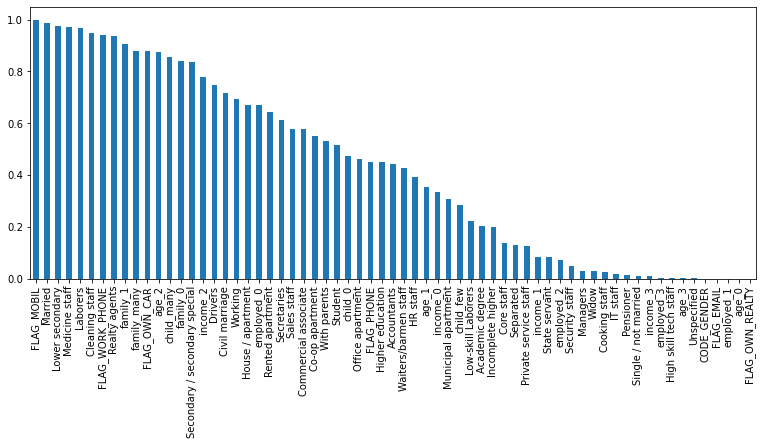

In [26]:
from sklearn.feature_selection import chi2
chi_scores = chi2(X_train,y_train)
p_values = pd.Series(chi_scores[1],index = X_train.columns)
p_values.sort_values(ascending = False , inplace = True)
plt.rcParams['figure.figsize'] = [13, 5]
p_values.plot.bar()

**Drop features with high p-value**

In [27]:
X_train.drop(p_values[p_values > 0.5].index, axis=1,inplace=True)
print(p_values[p_values > 0.5].index)

Index(['FLAG_MOBIL', 'Married', 'Lower secondary', 'Medicine staff',
       'Laborers', 'Cleaning staff', 'FLAG_WORK_PHONE', 'Realty agents',
       'family_1', 'family_many', 'FLAG_OWN_CAR', 'age_2', 'child_many',
       'family_0', 'Secondary / secondary special', 'income_2', 'Drivers',
       'Civil marriage', 'Working', 'House / apartment', 'employed_0',
       'Rented apartment', 'Secretaries', 'Sales staff',
       'Commercial associate', 'Co-op apartment', 'With parents', 'Student'],
      dtype='object')


#### Remaining features:

In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24832 entries, 5036557 to 5090768
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   CODE_GENDER            24832 non-null  int64
 1   FLAG_OWN_REALTY        24832 non-null  int64
 2   FLAG_PHONE             24832 non-null  int64
 3   FLAG_EMAIL             24832 non-null  int64
 4   child_0                24832 non-null  int64
 5   child_few              24832 non-null  int64
 6   income_0               24832 non-null  int64
 7   income_1               24832 non-null  int64
 8   income_3               24832 non-null  int64
 9   Pensioner              24832 non-null  int64
 10  State servant          24832 non-null  int64
 11  Academic degree        24832 non-null  int64
 12  Higher education       24832 non-null  int64
 13  Incomplete higher      24832 non-null  int64
 14  Separated              24832 non-null  int64
 15  Single / not married   24832

Apply to X_test

In [29]:
X_test = X_test[X_train.columns]

[Back to top](#s0)

## 5. Model building<a id='s5'></a>
Models will be built from XGBoost technology.<br>
The principal challenge will be building a model from a highly imbalanced training set that will (a) perform well and (b) generalize to the test set. Metric used will be AUCPR. Three approaches will be investigated:
1. Baseline (no special treatment
2. SMOTE upsampling technology to train on a balanced data set
3. Use of scale_pos_weight training hyperparameter in XGBoost<br><br>
 First we build two utility functions: (a) Build and evaulate models with CV over a grid of hyperparameters and (b) Test the model against the test dataset

In [40]:
import xgboost as xgb
import itertools
#
# Function to build and evaulate models with CV over a grid of hyperparameters
#
def gridXGB(paramlist, verbosity = 0):
    if verbosity > 0:
        print('train-aucpr\ttest-aucpr', end=' ')
        for param in paramlist:
            print('\t'+(param+' '*10)[:11], end=' ')
        print('\n')
    best = dict()
    s = list(paramlist.values())
    for paramset in itertools.product(*s):
        params = dict(zip(list(paramlist.keys()), list(paramset)))
        xgb_model = xgb.XGBClassifier(use_label_encoder=False, objective = 'binary:logistic')
        cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=3,
                        num_boost_round=50,early_stopping_rounds=10,metrics="aucpr",
                            as_pandas=True, seed=123, shuffle=True)
        if verbosity > 0:
            pst = "{:.4}".format(cv_results.tail(1)["train-aucpr-mean"].values[0])
            pst = pst + "\t\t{:.4}".format(cv_results.tail(1)["test-aucpr-mean"].values[0])
            for param in params.values():
                if isinstance(param,int):
                    pst = pst + "\t\t"+str(param)
                else:
                    pst = pst + "\t\t{:.4}".format(param)
            print(pst)
        if len(best) == 0 or best['test-aucpr'] < cv_results.tail(1)["test-aucpr-mean"].values[0]:
            best['train-aucpr'] = cv_results.tail(1)["train-aucpr-mean"].values[0]
            best['test-aucpr'] = cv_results.tail(1)["test-aucpr-mean"].values[0]
            best.update(params)
    print("\n Best values:")
    print('train-aucpr\ttest-aucpr', end=' ')
    for param in paramlist:
        print('\t'+(param+' '*10)[:11], end=' ')
    print('\n')
    pst = ""
    for best_val in best.values():
        if isinstance(best_val,int):
            pst = pst +str(best_val)+ "\t\t"
        else:
            pst = pst +"{:.4}".format(best_val)+ "\t\t"
    print(pst)

In [74]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
results = []
#
# Function to test model against test dataset
#
def test_model(params, X_train, y_train, X_test, y_test, name):
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, objective = 'binary:logistic',
            eval_metric = 'aucpr', **params)
    xgb_model.fit(X_train, y_train)
    preds = xgb_model.predict(X_test)
    c_report = classification_report(y_test, preds, output_dict=True)
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds))
    results.append({'model':name,
                    'precision':c_report['1']['precision'],
                   'recall':c_report['1']['recall'],
                   'f1':c_report['1']['f1-score']})

### 5.1 Baseline model

In [34]:
dmatrix = xgb.DMatrix(X_train,y_train)
gridXGB(paramlist={'max_depth':[4, 10, 16],
             'colsample_bytree': [0.3,0.5,0.7],
             'learning_rate' : [0.1, 0.4,0.7]}, verbosity=1)

train-aucpr	test-aucpr 	max_depth 	colsample_b 	learning_ra 

0.1711		0.1018		4		0.3		0.1
0.2143		0.1053		4		0.3		0.4
0.2292		0.1093		4		0.3		0.7
0.1836		0.1013		4		0.5		0.1
0.2362		0.1093		4		0.5		0.4
0.2632		0.1127		4		0.5		0.7
0.1868		0.1004		4		0.7		0.1
0.2468		0.1106		4		0.7		0.4
0.2755		0.1178		4		0.7		0.7
0.3159		0.1256		10		0.3		0.1
0.4001		0.1352		10		0.3		0.4
0.4323		0.1377		10		0.3		0.7
0.4414		0.144		10		0.5		0.1
0.5393		0.16		10		0.5		0.4
0.5126		0.1553		10		0.5		0.7
0.4713		0.1521		10		0.7		0.1
0.5779		0.1635		10		0.7		0.4
0.6055		0.1606		10		0.7		0.7
0.3174		0.1258		16		0.3		0.1
0.4016		0.1348		16		0.3		0.4
0.4335		0.1385		16		0.3		0.7
0.5024		0.1552		16		0.5		0.1
0.5346		0.1607		16		0.5		0.4
0.5607		0.1622		16		0.5		0.7
0.5857		0.1683		16		0.7		0.1
0.6002		0.169		16		0.7		0.4
0.6159		0.1644		16		0.7		0.7

 Best values:
train-aucpr	test-aucpr 	max_depth 	colsample_bytree 	learning_rate 

0.6002		0.169		16		0.7		0.4		


Comments: Wide discrepancy between train and test aucpr is evidence of serious overtraining. Performance is also poor. Introduce range of measures to reduce overfit

In [42]:
gridXGB(paramlist={'max_depth':[16],
             'colsample_bytree': [0.7],
             'learning_rate' : [0.4],
              'gamma' : [0, 1, 2],
              'lambda' : [1, 2, 3],
               'alpha' : [0, 1, 2]})


 Best values:
train-aucpr	test-aucpr 	max_depth   	colsample_b 	learning_ra 	gamma       	lambda      	alpha       

0.5907		0.1714		16		0.7		0.4		0		2		0		


Increasing lambda has helped a bit - explore more

In [43]:
gridXGB(paramlist={'max_depth':[16, 18, 20],
             'colsample_bytree': [0.6, 0.7, 0.8],
             'learning_rate' : [0.3, 0.4, 0.5],
              'lambda' : [1.5, 2.0, 2.5]})


 Best values:
train-aucpr	test-aucpr 	max_depth   	colsample_b 	learning_ra 	lambda      

0.6268		0.1758		20		0.8		0.3		2.0		


Seems like we are increasingly complexity and overfitting. Try subsample.

In [44]:
gridXGB(paramlist={'max_depth':[16, 18, 20],
             'colsample_bytree': [0.6, 0.7, 0.8],
             'learning_rate' : [0.3],
              'lambda' : [2],
              'subsample' : [0.2,0.6,1.0]})


 Best values:
train-aucpr	test-aucpr 	max_depth   	colsample_b 	learning_ra 	lambda      	subsample   

0.5981		0.1766		18		0.8		0.3		2		0.6		


A little better. We will leave colsample_bytree at default of 1.0 and learning_rate at default of 0.3 and explore subsample in finer detail:

In [45]:
gridXGB(paramlist={'max_depth':[16, 18, 20],
              'lambda' : [2],
              'subsample' : [0.3,0.4,0.5,0.6,0.7,0.8]})


 Best values:
train-aucpr	test-aucpr 	max_depth   	lambda      	subsample   

0.589		0.1764		20		2		0.5		


This is poor performance with little indication that further tuning of hyperparameters will help. Evaluate on test set:

In [75]:
test_model({'max_depth':20, 'lambda':2, 'subsample':0.5}, X_train, y_train, X_test, y_test, 'Baseline')

[[7651   86]
 [ 486   55]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      7737
           1       0.39      0.10      0.16       541

    accuracy                           0.93      8278
   macro avg       0.67      0.55      0.56      8278
weighted avg       0.90      0.93      0.91      8278



Aggregate performance measures look good (accuracy 93%, weighted f1 91%), but this conceals poor performace of the positive class. False negatives  are particularly high (486) compared with true positives (55). A a result recall is extremely low - 10%. The f1 score for the positive class is 0.16.

### 5.2 SMOTE upsampling

In [51]:
import imblearn
oversample = imblearn.over_sampling.SMOTEN() # version of SMOTE for categorical variables
X_over, y_over = oversample.fit_resample(X_train, y_train)
dmatrix = xgb.DMatrix(X_over,y_over)
gridXGB(paramlist={'max_depth':[4, 8, 12],
             'colsample_bytree': [0.3, 0.7, 1.0],
             'learning_rate' : [0.2, 0.4, 0.6]})


 Best values:
train-aucpr	test-aucpr 	max_depth   	colsample_b 	learning_ra 

0.9494		0.9313		12		0.7		0.4		


Performance has been vastly improved, and seemingly overtraining is now minimal. Fine tune parameters:

In [52]:
gridXGB(paramlist={'max_depth':[10,12,14],
             'colsample_bytree': [0.7,0.8,0.9],
             'learning_rate' : [0.3, 0.4, 0.5]})


 Best values:
train-aucpr	test-aucpr 	max_depth   	colsample_b 	learning_ra 

0.9515		0.9339		14		0.7		0.3		


Improvement is marginal. Keep max_depth at 12, colsample_bytree at 0.7 and learning_rate at default 0.3. Look at impact of alpha, gamma and lambda.

In [53]:
gridXGB(paramlist={'max_depth':[12],
             'colsample_bytree': [0.7],
             'gamma' : [0,1,2],
              'alpha' : [0,1,2],
              'lambda': [1,2,3]})


 Best values:
train-aucpr	test-aucpr 	max_depth   	colsample_b 	gamma       	alpha       	lambda      

0.9495		0.9326		12		0.7		0		0		2		


No improvement Finally try subsample:

In [54]:
gridXGB(paramlist={'max_depth':[12],
             'colsample_bytree': [0.7],
             'subsample' : [0.3,0.5,0.7,0.9,1.0]})


 Best values:
train-aucpr	test-aucpr 	max_depth   	colsample_b 	subsample   

0.9493		0.9319		12		0.7		0.7		


We will fix model at {'max_depth':12,'colsample_bytree':0.7} and evaluate

In [76]:
test_model({'max_depth':12,'colsample_bytree':0.7}, X_over, y_over, X_test, y_test, 'SMOTE')

[[6534 1203]
 [ 381  160]]
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      7737
           1       0.12      0.30      0.17       541

    accuracy                           0.81      8278
   macro avg       0.53      0.57      0.53      8278
weighted avg       0.89      0.81      0.84      8278



Aggregate performance measures look marginally worse (accuracy 81%, weighted f1 84%), and again this conceals poor performace of the positive class. This time false positives are the problem (1203) compared with 160 true positives.  A a result precision is now extremely low: 12%. The f1 score for the positive class is 0.17.

### 5.3 scale_pos_weight training

In [59]:
dmatrix = xgb.DMatrix(X_train,y_train)
gridXGB(paramlist={'max_depth':[10, 15, 20],
                    'lambda':[1, 2, 4],
                    'subsample':[0.5, 0.8, 1.0],
                    'scale_pos_weight' : [1, 8, 16, 32]})


 Best values:
train-aucpr	test-aucpr 	max_depth   	lambda      	subsample   	scale_pos_w 

0.5908		0.1787		20		2		0.8		8		


Fine tuning

In [60]:
gridXGB(paramlist={'max_depth':[20],
                    'lambda':[1.5, 2, 2.5],
                    'subsample':[0.7, 0.8, 0.9],
                    'scale_pos_weight' : [6, 8, 10]})


 Best values:
train-aucpr	test-aucpr 	max_depth   	lambda      	subsample   	scale_pos_w 

0.5999		0.1803		20		1.5		0.9		10		


Further tuning:

In [61]:
gridXGB(paramlist={'max_depth':[20],
                    'lambda':[1.0, 1.25, 1.5],
                    'subsample':[0.8, 0.9,1.0],
                    'scale_pos_weight' : [8, 10,12]})


 Best values:
train-aucpr	test-aucpr 	max_depth   	lambda      	subsample   	scale_pos_w 

0.5999		0.1803		20		1.5		0.9		10		


In [77]:
test_model({'max_depth':20,'lambda':1.5,'subsample':0.9, 'scale_pos_weight':10}, X_train, y_train, X_test, y_test,'Scale')

[[6517 1220]
 [ 302  239]]
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      7737
           1       0.16      0.44      0.24       541

    accuracy                           0.82      8278
   macro avg       0.56      0.64      0.57      8278
weighted avg       0.90      0.82      0.85      8278



Results are skewed in the same direction as SMOTE: recall achieved at the expense of precision. But overall performance is better. The f1 score for the positive class has improved to 0.24.

### 5.4 Ensemble
As a final step let's try a hybrid between model 1 and 3 - effectively an ensemble:

In [83]:
test_model({'max_depth':20,'lambda':1.75,'subsample':0.7, 'scale_pos_weight':5}, X_train, y_train, X_test, y_test,'Hybrid')

[[7132  605]
 [ 359  182]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      7737
           1       0.23      0.34      0.27       541

    accuracy                           0.88      8278
   macro avg       0.59      0.63      0.61      8278
weighted avg       0.90      0.88      0.89      8278



There is greater balance here - the f1 score for the positive class has inproved further to 0.27.

[Back to top](#s0)

## 6. Model evaluation<a id='s6'></a>

In [84]:
print(pd.DataFrame(results))

      model  precision    recall        f1
0  Baseline   0.390071  0.101664  0.161290
1     SMOTE   0.117388  0.295749  0.168067
2     Scale   0.163811  0.441774  0.239000
3    Hybrid   0.231258  0.336414  0.274096


### Comments
1. Class imbalance seems to be a major challenge with this dataset. Training on the unbalanced data biases the model heavily in favour of precision, while rebalancing favours recall. Scaling the positive class during training performs better than oversampling. A reasonable compromise is achieved by a hybrid of the scaled and unscaled models.
2. But the performance is poor overall. Our best model identifies only 34% of credit risks, which is hardly a sustainable way to proceed in the financial services business!

### Feature importance

In [94]:
params = {'max_depth':20,'lambda':1.75,'subsample':0.7, 'scale_pos_weight':5}
xgb_model = xgb.XGBClassifier(use_label_encoder=False, objective = 'binary:logistic',
            eval_metric = 'aucpr', **params)
xgb_model.fit(X_train, y_train)
imp = pd.Series(xgb_model.feature_importances_)
imp.index = X_train.columns
imp.sort_values(ascending=False)

Waiters/barmen staff     0.039305
HR staff                 0.034476
child_few                0.033535
Office apartment         0.031908
Pensioner                0.031674
Accountants              0.030029
income_0                 0.029585
income_1                 0.028911
State servant            0.028756
employed_2               0.028721
Security staff           0.028577
age_3                    0.028543
Private service staff    0.028432
Widow                    0.028416
FLAG_PHONE               0.028381
Incomplete higher        0.028242
Separated                0.028106
income_3                 0.028034
Unspecified              0.028015
Municipal apartment      0.027893
High skill tech staff    0.027757
employed_3               0.027733
FLAG_EMAIL               0.027701
child_0                  0.027600
Core staff               0.027276
Managers                 0.027203
age_0                    0.027129
employed_1               0.027058
age_1                    0.026963
Higher educati

There is no evidence of opportunity to simplify the model further through feature reduction, apart from removing *Academic degree* and *FLAG_OWN_REALTY*. Neither is there any real transaprency on the model. 

[Back to top](#s0)

## 7. Conclusions<a id='s7'></a>
The model performs poorly - only 34% of risky applications are identified. In reality of course credit history forms a major part of credit decisions, and the way this task is formulated makes that impossible, since credit history is used to label the data. It would be an exercise in futility to build a model to predict credit history on the basis of credit history. A substantially better model would require an alternative method of labelling data to release credit history as a key feature, and sourcing of further features, such as details of other financial obligations.

[Back to top](#s0)